In [1]:
%load_ext autoreload
%autoreload 2

import os
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
from lightgbm import LGBMClassifier
from scipy.stats import ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

from utils import utils

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

/home/cgpimenta/miniconda3/envs/neurotech/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Leitura dos arquivos de configuração

In [2]:
data_config = utils.read_yaml('config/data.yaml')

id_var = data_config['id_var']
date_var = data_config['date_var']
ym_var = data_config['ym_var']
target_var = data_config['target_var']
age_var = data_config['age_var']

In [3]:
model_config = utils.read_yaml('config/model.yaml')

seed = model_config['seed']
num_evals_hpo = model_config['num_evals_hpo']
feat_sel_config = model_config['feat_selection']
artifacts_config = model_config['artifacts']

# Leitura dos dados

In [4]:
data_train = pd.read_csv(data_config['train_data_file'])
data_test = pd.read_csv(data_config['test_data_file'])
data_oot = pd.read_csv(data_config['oot_data_file'])
data_train.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR37,VAR38,VAR39,VAR40,VAR41,VAR42,VAR43,VAR44,VAR45,VAR46,VAR47,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,BAIXA,1.0,0.182,NaN,0.141,NaN,0.416667,NaN,1.263014,NaN,NaN,NaN,NaN,NaN,0.034,NaN,NaN,NaN,0.0,NaN,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512334,0.486768,0.357526,0.538737,NaN,NaN,NaN,NaN,0.046,NaN,S,N,N,N,N,N,N,N,N,N,N,N,S,N,N,N,N,MEDIA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,ALTISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTA,ALTISSIMA,ALTISSIMA,MEDIA,BAIXISSIMA,ALTISSIMA,MEDIA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,MEDIA,ALTA,BAIXISSIMA,ALTA,LONGE,LONGE,LONGE,PROXIMO,MEDIO,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,MUITO LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,MEDIO,LONGE,MUITO LONGE,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,MEDIA,0.0,NaN,NaN,0.136,0.127,NaN,NaN,0.654795,1.545205,NaN,NaN,0.125,NaN,0.017,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.328021,0.447454,0.414335,0.485512,NaN,NaN,NaN,NaN,0.099,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,ALTISSIMA,ALTA,BAIXISSIMA,ALTA,ALTISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTISSIMA,MEDIA,MEDIA,ALTA,BAIXISSIMA,ALTA,ALTA,MEDIA,ALTISSIMA,ALTA,ALTA,ALTA,ALTA,MEDIA,BAIXISSIMA,ALTISSIMA,MEDIA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,MEDIA,MEDIO,LONGE,MEDIO,MUITO LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,LONGE,LONGE,LONGE,LONGE,PROXIMO,LONGE,PROXIMO,PROXIMO,MUITO LONGE,MEDIO,MEDIO,PROXIMO,PROXIMO,PROXIMO,LONGE,MEDIO,PROXIMO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,ALTISSIMA,NaN,0.095,NaN,0.152,NaN,0.166667,NaN,1.665753,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,124.0,NaN,0.627262,0.730539,0.916771,0.519726,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,N,N,S,N,N,N,N,N,N,S,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,PROXIMO,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015
3,2017-08-05 00:00:00

In [5]:
data_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Columns: 151 entries, REF_DATE to ID
dtypes: float64(34), int64(3), object(114)
memory usage: 809.4 MB


## Criação da variável de safra (ano + mês)

Para facilitar as análises, a safra (ano e mês) da contratação foi extraída da variável de data. Os conjuntos de treino e teste correspondem às safras de janeiro a agosto de 2017, enquanto o conjunto out-of-time (OOT) contém as safras de setembro a dezembro do mesmo ano.

O público está bem distribuído ao longo de todos os meses, sem nenhuma concentração relevante em um mês específico.

In [6]:
data_train[ym_var] = data_train[date_var].str[:4] + data_train[date_var].str[5:7]
data_train = data_train.sort_values(by=ym_var).reset_index(drop=True)

print('Distribuição das safras no conjunto de treino:')
utils.value_counts(data_train[ym_var])

Distribuição das safras no conjunto de treino:


,qtd,%
REF,,
201701,"14,537",12.0%
201702,"13,697",11.3%
201703,"16,046",13.3%
201704,"13,500",11.2%
201705,"14,220",11.8%
201706,"15,057",12.5%
201707,"16,445",13.6%
201708,"17,248",14.3%


In [7]:
data_test[ym_var] = data_test[date_var].str[:4] + data_test[date_var].str[5:7]
data_test = data_test.sort_values(by=ym_var).reset_index(drop=True)

print('Distribuição das safras no conjunto de teste:')
utils.value_counts(data_test[ym_var])

Distribuição das safras no conjunto de teste:


,qtd,%
REF,,
201701,"6,224",12.0%
201702,"6,004",11.6%
201703,"6,842",13.2%
201704,"5,718",11.0%
201705,"6,095",11.8%
201706,"6,511",12.6%
201707,"7,052",13.6%
201708,"7,305",14.1%


In [8]:
data_oot[ym_var] = data_oot[date_var].str[:4] + data_oot[date_var].str[5:7]
data_oot = data_oot.sort_values(by=ym_var).reset_index(drop=True)

print('Distribuição das safras no conjunto OOT:')
utils.value_counts(data_oot[ym_var])

Distribuição das safras no conjunto OOT:


,qtd,%
REF,,
201709,"23,864",25.9%
201710,"23,015",25.0%
201711,"23,260",25.3%
201712,"21,826",23.7%


# Análise exploratória

## Variável resposta

A taxa de inadimplência do público é de 24,5%, tanto no treino quanto no teste. Entretanto, a safra 201703 apresenta um salto para aproximadamente 50%. Idealmente, o comportamento do público nessa safra deveria ser avaliado em detalhes para entender o motivo do aumento repentino de inadimplência. Neste projeto, optou-se por remover a safra das análises para não interferir nos resultados.

Após remoção da safra problemática, é possível observar uma leve tendência de redução da taxa de inadimplência ao longo do tempo.

In [9]:
def plot_monthly_pd(
    data_train: pd.DataFrame,
    data_test: pd.DataFrame,
    ym_var: str,
    target_var: str
) -> None:
    '''Criar um gráfico da taxa de inadimplência ao longo do tempo para os
    conjuntos de treino e teste

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
    data_test: pandas.DataFrame
        Dados de teste.
    ym_var: str
        Nome da variável de safra.
    target_var: str
        Nome da variável de indicador de inadimplência.
    '''
    plt.figure(figsize=(10, 4))

    sns.lineplot(
        data=data_train, x=ym_var, y=target_var, label='Treino'
    )
    sns.lineplot(
        data=data_test, x=ym_var, y=target_var, label='Teste'
    )

    plt.ylim(bottom=0)
    plt.xlabel('Safra')
    plt.ylabel('PD')
    plt.legend(title='Conjunto')
    plt.title('Taxa de inadimplência por safra')

    plt.show()

In [10]:
print('Treino:')
display(utils.value_counts(data_train[target_var]))
print()
print('Teste:')
utils.value_counts(data_test[target_var])

Treino:


,qtd,%
TARGET,,
0,"91,163",75.5%
1,"29,587",24.5%



Teste:


,qtd,%
TARGET,,
0,"39,071",75.5%
1,"12,680",24.5%


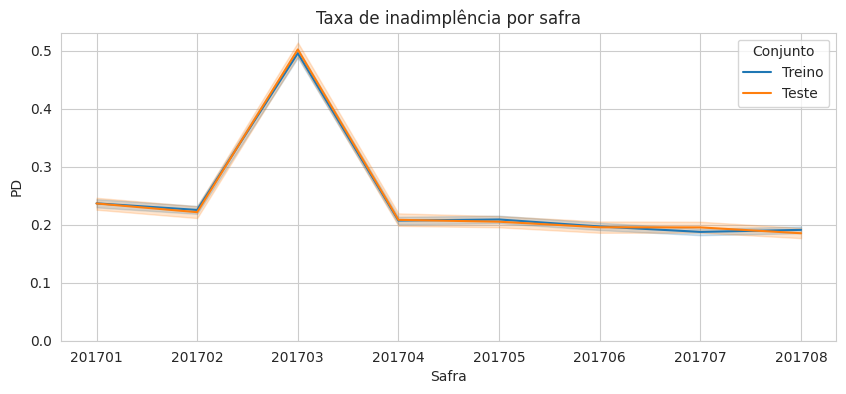

In [11]:
plot_monthly_pd(data_train, data_test, ym_var, target_var)

In [12]:
# Remover a safra com taxa de inadimplência alta
data_train = data_train[data_train[ym_var] != '201703'].reset_index(drop=True)
data_test = data_test[data_test[ym_var ]!= '201703'].reset_index(drop=True)

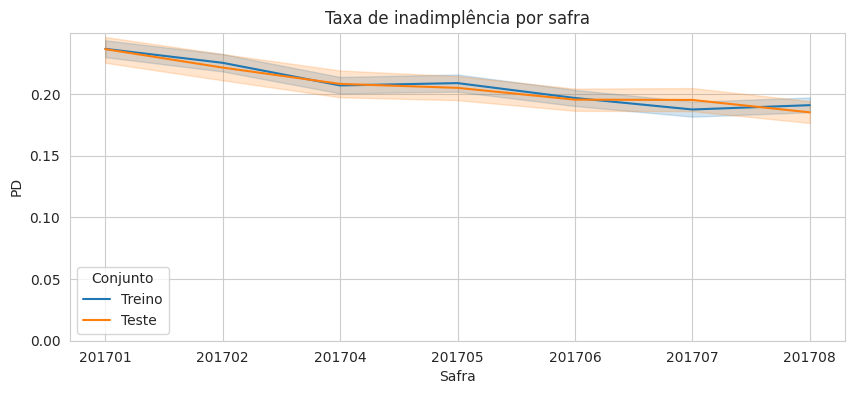

In [13]:
plot_monthly_pd(data_train, data_test, ym_var, target_var)

## Variável `ID`

A variável de ID é única dentro de cada conjunto e não há nenhuma repetição dos IDs do treino no teste e no OOT, então não foi necessário fazer nenhum tratamento.

In [14]:
# Verificar se há IDs repetidos dentro de cada conjunto

id_cnt_train = data_train[id_var].value_counts()
id_cnt_test = data_test[id_var].value_counts()
id_cnt_oot = data_oot[id_var].value_counts()

if id_cnt_train.max() > 1:
    print('Há IDs repetidos no treino.')

if id_cnt_test.max() > 1:
    print('Há IDs repetidos no teste.')

if id_cnt_oot.max() > 1:
    print('Há IDs repetidos no OOT.')

In [15]:
# Verificar se há IDs do treino no teste e OOT

ids_train = set(data_train[id_var].unique())
ids_test = set(data_test[id_var].unique())
ids_oot = set(data_oot[id_var].unique())

ids_train_test = ids_train.intersection(ids_test)
ids_train_oot = ids_train.intersection(ids_oot)

print('Número de IDs do treino repetidos no teste:', len(ids_train_test))
print('Número de IDs do treino repetidos no OOT:  ', len(ids_train_oot))

Número de IDs do treino repetidos no teste: 0
Número de IDs do treino repetidos no OOT:   0


## Variáveis numéricas

A base de dados contém 34 variáveis preditoras numéricas, muitas delas com valores *outlier*.

In [16]:
num_vars_all = data_train.drop(
    columns=[id_var, age_var, target_var]
).select_dtypes(include='number').columns.to_list()

print('Número de variáveis numéricas:', len(num_vars_all))

Número de variáveis numéricas: 34


In [17]:
data_train[num_vars_all].describe().map(lambda x: f'{x:,.2f}')

,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR37,VAR39,VAR40,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147
count,"101,773.00","101,773.00","64,545.00","56,899.00","13,414.00","82,473.00","50,423.00","39,118.00","13,414.00","82,473.00","50,423.00","9,846.00","13,471.00","50,474.00","13,414.00","84,285.00","50,423.00",891.00,924.00,"11,009.00","21,436.00","11,009.00","21,752.00","104,640.00","101,831.00","102,128.00","92,233.00",356.00,244.00,"104,704.00","104,704.00",594.00,147.00,"104,704.00"
mean,-14.40,-45.88,0.24,0.22,0.31,0.15,0.19,2.04,2.16,1.00,1.26,0.04,0.35,0.21,0.09,0.08,0.06,0.36,0.02,0.00,0.14,0.20,150.37,0.46,0.53,0.63,0.50,"1,612.88","6,910.00",0.26,"1,850.78","4,038.68","1,994.55",101.84
std,8.99,7.55,0.62,0.26,0.24,0.12,0.19,3.18,2.18,0.50,1.13,0.12,0.19,0.18,0.13,0.14,0.12,0.23,0.04,0.04,0.15,0.16,82.62,0.14,0.12,0.22,0.07,"2,115.35","4,752.90",0.41,882.86,"3,593.49","3,076.26",0.54
min,-33.52,-72.90,-4.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.00,0.05,0.21,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,100.00
25%,-22.85,-49.90,0.00,0.04,0.06,0.10,0.08,0.25,0.51,0.50,0.35,0.00,0.25,0.12,0.01,0.00,0.00,0.17,0.00,0.00,0.04,0.12,102.00,0.36,0.45,0.44,0.46,631.86,"3,733.32",0.00,"1,510.23","1,658.40",0.00,102.00
50%,-13.00,-46.56,0.00,0.13,0.32,0.13,0.11,0.75,0.84,1.07,1.20,0.01,0.25,0.12,0.04,0.03,0.00,0.33,0.00,0.00,0.10,0.12,134.00,0.46,0.51,0.54,0.50,769.00,"5,218.40",0.00,"1,623.52","3,024.48",937.00,102.00
75%,-6.37,-38.99,0.00,0.29,0.51,0.16,0.15,2.42,4.12,1.43,1.48,0.03,0.50,0.25,0.10,0.09,0.07,0.50,0.03,0.00,0.19,0.25,182.00,0.56,0.58,0.90,0.52,"1,653.75","9,558.37",0.41,"1,815.14","5,265.05","2,382.05",102.00
max,4.60,-32.43,4.00,1.00,1.00,1.00,1.00,16.00,9.00,2.47,7.41,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.37,1.00,1.00,1.00,902.00,0.95,0.92,1.00,0.91,"17,374.94","26,523.92",1.00,"29,058.33","25,347.40","17,229.20",102.00


# Variáveis categóricas

Há 113 variáveis categóricas no conjunto de dados. Algumas delas aparentam ser ordinais, enquanto outras são nominais.

Oito variáveis categóricas possuem apenas dois valores distintos (incluindo *missing*), sendo que uma delas, `VAR149`, é uma constante e foi removida.

In [18]:
cat_vars_all = data_train.drop(
    columns=[date_var, ym_var]
).select_dtypes(include='object').columns.to_list()

print('Número de variáveis categóricas:', len(cat_vars_all))

Número de variáveis categóricas: 113


In [19]:
data_train[cat_vars_all].head()

,VAR2,VAR4,VAR5,VAR8,VAR9,VAR10,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR38,VAR43,VAR45,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR142,VAR143,VAR144,VAR148,VAR149
0,F,NaN,PA,E,E,ALTISSIMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO PROXIMO,E,NaN,NaN,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1,NaN,NaN,PI,NaN,E,ALTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MEDIO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,E,NaN,NaN,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
2,F,NaN,BA,NaN,E,ALTISSIMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,MEDIO,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO PROXIMO,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MEDIO,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO PROXIMO,LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO PROXIMO,E,NaN,NaN,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
3,F,NaN,SP,C,E,BAIXA,BANCO ITAU,CREDITADA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,S,N,N,S,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,MEDIA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSI

In [20]:
cat_vars_card = {}

for var in cat_vars_all:
    cat_vars_card[var] = len(data_train[var].unique())

cat_vars_card = pd.Series(cat_vars_card)

print('Menores cardinalidades:')
display(cat_vars_card.sort_values().head())
print()
print('Maiores cardinalidades:')
display(cat_vars_card.sort_values(ascending=False).head())

Menores cardinalidades:


VAR149    1
VAR4      2
VAR43     2
VAR36     2
VAR38     2
dtype: int64


Maiores cardinalidades:


VAR34     35
VAR5      28
VAR32      8
VAR31      8
VAR148     8
dtype: int64

In [21]:
cat_vars_bottom_card = cat_vars_card[cat_vars_card <= 2].index.to_list()

print('Variáveis com cardinalidade <= 2:')
print(cat_vars_bottom_card)

Variáveis com cardinalidade <= 2:
['VAR4', 'VAR33', 'VAR35', 'VAR36', 'VAR38', 'VAR43', 'VAR45', 'VAR149']


In [22]:
for var in cat_vars_bottom_card:
    display(utils.value_counts(data_train[var]))

,qtd,%
VAR4,,
S,176,0.2%
NaN,"104,528",99.8%


,qtd,%
VAR33,,
S,"7,437",7.1%
NaN,"97,267",92.9%


,qtd,%
VAR35,,
S,"22,682",21.7%
NaN,"82,022",78.3%


,qtd,%
VAR36,,
S,"21,752",20.8%
NaN,"82,952",79.2%


,qtd,%
VAR38,,
S,656,0.6%
NaN,"104,048",99.4%


,qtd,%
VAR43,,
S,356,0.3%
NaN,"104,348",99.7%


,qtd,%
VAR45,,
S,244,0.2%
NaN,"104,460",99.8%


,qtd,%
VAR149,,
2.6.1,"104,704",100.0%


In [23]:
# Remover a variável com um único valor
cat_vars_all.remove('VAR149')

# Pré-processamento e seleção de variáveis

In [24]:
exp_vars_all = num_vars_all + cat_vars_all

X_train, y_train = data_train[exp_vars_all], data_train[target_var]
X_test, y_test = data_test[exp_vars_all], data_test[target_var]
X_oot = data_oot[exp_vars_all]

## Valores faltantes

A presença de valores faltantes (*missing*) foi avaliada tanto por variável quanto por observação. As variáveis com mais de 90% de missing foram removidas. Esse processo removeu sete variáveis numéricas e 10 categóricas. Cinco das sete variáveis categóricas com apenas dois valores distintos descritas anteriormente foram removidas.

Mais de 95% das observações contém menos de 40% das variáveis com valor *missing*, portanto nenhum tratamento foi feito.

In [25]:
def plot_missing_distrib(
    data: pd.Series,
    axis: str,
    bins: Optional[int] = 10,
    stat: Optional[str] = 'count',
    var_type: Optional[str] = None
) -> None:
    '''Criar um gráfico com a distribuição de valores faltantes.
    
    Params
    ------
    data: pandas.Series
        Série com a porcentagem de valores faltantes por variável ou por
        observação.
    axis: {'vars', 'obs'}
        Valores faltantes por variável ou por observação.
    bins: Optional[int] (default=10)
        Número de bins do histograma.
    stat: {'count', 'percent'} (default='count')
        Estatística a ser computada.
    var_type: {'num', 'cat'} (default=None)
        Tipo das variáveis sendo avaliadas.
    '''
    assert axis in ['vars', 'obs'], \
        "'axis' deve ser 'vars' ou 'obs'."
    assert stat in ['count', 'percent'], \
        "'stat' deve ser 'count' ou 'percent'."
    assert var_type in [None, 'num', 'cat'], \
        "'var_type' deve ser 'num' ou 'cat'."

    axis = 'variáveis' if axis == 'vars' else 'observações'

    if var_type is not None:
        var_type = 'numéricas' if var_type == 'num' else 'categóricas'
    else:
        var_type = ''

    ylabel_dict = {
        'count': f'# {axis}',
        'percent': f'% {axis}'
    }
    xlabel_dict = {
        'variáveis': '% observações com missing',
        'observações': '% variáveis com missing'
    }

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    plt.tight_layout()

    sns.histplot(data=data, bins=bins, kde=True, stat=stat, ax=ax[0])
    sns.histplot(data=data, bins=bins, stat=stat, cumulative=True, ax=ax[1])

    ax[0].set_title(f'Distrib de missing nas {axis} {var_type}')
    ax[0].set_ylabel(ylabel_dict[stat])
    ax[0].set_xlabel(xlabel_dict[axis])
    ax[0].xaxis.grid(False)

    ax[1].set_title(f'Distrib cumulativa de missing nas {axis} {var_type}')
    ax[1].set_xlabel(xlabel_dict[axis])
    ax[1].xaxis.grid(False)

    sns.despine()
    plt.show()

In [26]:
missing_per_num_var = data_train[num_vars_all].isna().mean()
missing_per_cat_var = data_train[cat_vars_all].isna().mean()
missing_per_var = data_train[exp_vars_all].isna().mean()
missing_per_obs = data_train.isna().mean(axis=1)

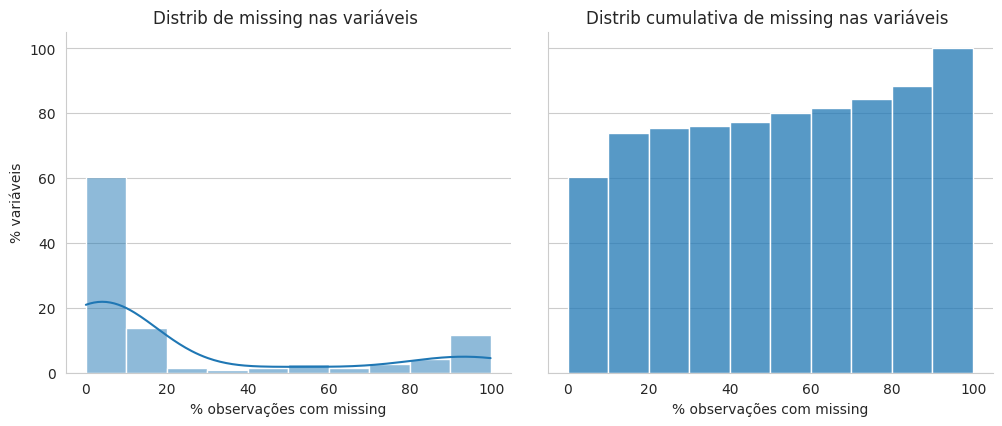

In [27]:
plot_missing_distrib(data=missing_per_var * 100, axis='vars', stat='percent')

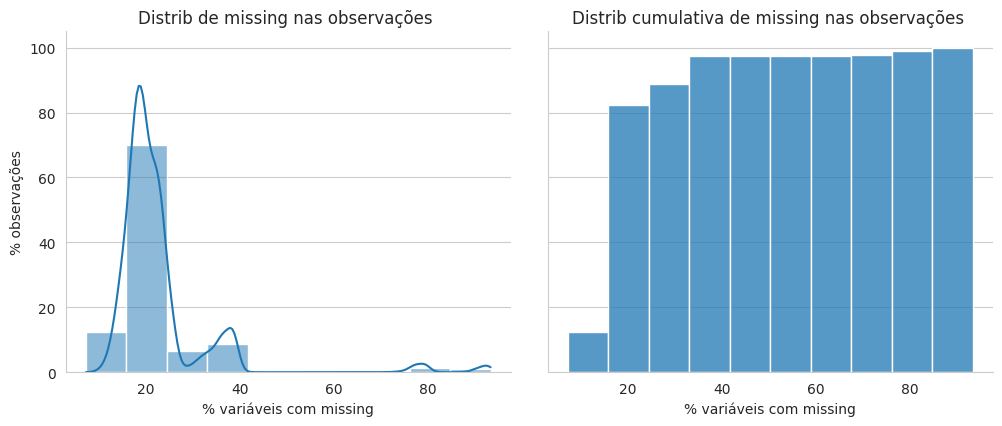

In [28]:
plot_missing_distrib(data=missing_per_obs * 100, axis='obs', stat='percent')

In [29]:
missing_thr = feat_sel_config['missing_threshold']

drop_num_vars = missing_per_num_var[
    missing_per_num_var > missing_thr
].index.to_list()
drop_cat_vars = missing_per_cat_var[
    missing_per_cat_var > missing_thr
].index.to_list()

In [30]:
qty_drop_num_vars = len(drop_num_vars)
qty_drop_cat_vars = len(drop_cat_vars)
qty_drop_vars = qty_drop_num_vars + qty_drop_cat_vars
qty_vars = len(exp_vars_all)

print('Variáveis removidas por missing:\n')
txt_num = f'Numéricas:   {qty_drop_num_vars:02d} ({qty_drop_num_vars / len(num_vars_all):05.1%})'
txt_cat = f'Categóricas: {qty_drop_cat_vars:02d} ({qty_drop_cat_vars / len(cat_vars_all):05.1%})'
txt_all = f'Total:       {qty_drop_vars:02d} ({qty_drop_vars / qty_vars:05.1%})'
print('   ' + txt_num)
print('   ' + txt_cat)
print('   ' + '-' * len(txt_cat))
print('   ' + txt_all)

Variáveis removidas por missing:

   Numéricas:   07 (20.6%)
   Categóricas: 10 (08.9%)
   -----------------------
   Total:       17 (11.6%)


In [31]:
print('Variáveis categóricas com baixa cardinalidade removidas por missing:')
set(drop_cat_vars).intersection(set(cat_vars_bottom_card))

Variáveis categóricas com baixa cardinalidade removidas por missing:


{'VAR33', 'VAR38', 'VAR4', 'VAR43', 'VAR45'}

In [32]:
num_vars_miss = [var for var in num_vars_all if var not in drop_num_vars]
cat_vars_miss = [var for var in cat_vars_all if var not in drop_cat_vars]

exp_vars_miss = num_vars_miss + cat_vars_miss

## Imputação e padronização

Os valores *missing* foram preenchidos com a mediana do conjunto de treino, no caso das variáveis numéricas, ou com uma categoria especial, no caso das variáveis categóricas. Em seguida, as variáveis numéricas foram padronizadas usando o algoritmo RobustScaler, que é capaz de lidar com *outliers*. O algoritmo foi treinado nos dados de treino e aplicado aos conjuntos de teste e OOT.

In [33]:
def preproc_data(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    X_oot: pd.DataFrame,
    preproc_pipeline_file: str
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''Executar pré-processamento dos dados.

    O pré-processamento inclui imputação de dados faltantes e padronização.
    Os modelos são treinados nos dados de treino e aplicados aos conjuntos
    de teste e OOT.

    Params
    ------
    X_train: pandas.DataFrame
        Conjunto de treino.
    X_test: pandas.DataFrame
        Conjunto de teste.
    X_oot: pandas.DataFrame
        Conjunto de OOT.
    preproc_pipeline_file: str
        Nome do arquivo a ser salvo com o pipeline de pré-processamento.

    Retorna
    -------
    Tuple[pandas.DataFrame, pandas.DataFrame, pandas.DataFrame]
        Conjuntos de treino, teste e OOT pré-processados.
    '''
    # Imputar valores missing e padronizar dados de acordo com o treino
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    X_train_preproc = pipeline.fit_transform(X_train)
    X_test_preproc = pipeline.transform(X_test)
    X_oot_preproc = pipeline.transform(X_oot)

    X_train_preproc = pd.DataFrame(X_train_preproc, columns=X_train.columns)
    X_test_preproc = pd.DataFrame(X_test_preproc, columns=X_test.columns)
    X_oot_preproc = pd.DataFrame(X_oot_preproc, columns=X_oot.columns)

    # Salvar os modelos
    utils.save_pickle(pipeline, preproc_pipeline_file)

    return X_train_preproc, X_test_preproc, X_oot_preproc

In [34]:
# Pré-processamento das variáveis numéricas
X_train_num_preproc, X_test_num_preproc, X_oot_num_preproc = preproc_data(
    X_train[num_vars_miss],
    X_test[num_vars_miss],
    X_oot[num_vars_miss],
    preproc_pipeline_file=os.path.join(
        artifacts_config['dir'],
        artifacts_config['preproc_pipeline_file']
    )
)

# Imputação das variáveis categóricas
X_train_cat_preproc = X_train[cat_vars_miss].fillna('VAZIO')
X_test_cat_preproc = X_test[cat_vars_miss].fillna('VAZIO')
X_oot_cat_preproc = X_oot[cat_vars_miss].fillna('VAZIO')

In [35]:
X_train_preproc = X_train_num_preproc.join(X_train_cat_preproc).join(data_train[ym_var])
X_test_preproc = X_test_num_preproc.join(X_test_cat_preproc).join(data_test[ym_var])
X_oot_preproc = X_oot_num_preproc.join(X_oot_cat_preproc).join(data_oot[ym_var])

In [36]:
X_train_preproc.head()

,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR21,VAR22,VAR23,VAR24,VAR25,VAR28,VAR29,VAR30,VAR37,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR147,VAR2,VAR5,VAR8,VAR9,VAR10,VAR32,VAR35,VAR36,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR142,VAR148,REF
0,0.724316,-0.151115,0.0,-3.703704,0.000,0.000000,0.000,-0.25,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000,0.0,0.084,0.0,0.0,-0.133813,-0.400330,0.875761,0.148587,-0.007282,-0.810941,0.0,F,PA,E,E,ALTISSIMA,VAZIO,VAZIO,VAZIO,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO PROXIMO,E,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,201701
1,0.527502,0.402069,0.0,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000,0.0,0.000,0.0,0.0,-0.099072,2.639782,0.948844,0.000000,-0.007282,-0.810941,0.0,VAZIO,PI,VAZIO,E,ALTA,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,VAZIO,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MEDIO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,E,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,201701
2,-0.022947,0.708006,0.0,0.000000,0.000,-3.093023,0.000,0.00,0.000000,-1.306051,0.000000,0.0,0.000,0.000,-0.492754,0.000,0.0,0.000,0.0,0.0,0.326851,0.348897,0.906433,0.272376,-0.007282,-0.706894,0.0,F,BA,VAZIO,E,ALTISSIMA,VAZIO,VAZIO,VAZIO,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,MEDIO,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO PROXIMO,MUITO 

## Seleção de variáveis

Após remover algumas variáveis pelo critério de *missing*, foi feita uma nova seleção com base na estabilidade ao longo das safras e na presença de colinearidade.

A estabilidade das variáveis foi avaliada por meio do Índice de Estabilidade Populacional (PSI, do inglês *Population Stability Index*), usando a primeira safra do treino (201701) como referência. Utilizando um valor limite de PSI de 0,2, quatro variáveis foram consideradas instáveis e foram removidas.

Multicolinearidade é a presença de variáveis independentes altamente correlacionadas no conjunto de dados, o que significa que uma variável pode ser predita por outras variáveis com alta acurácia. Tal comportamento pode afetar negativamente o desempenho de algoritmos lineares e que dependem da estimativa de coeficientes, como regressão linear ou logística e SVM, por exemplo.

A multicolinearidade pode ser identificada pelo Fator de Inflação da Variância (VIF, do inglês *Variance Inflation Factor*), que é uma métrica que mede o tanto que uma variável pode ser prevista por um modelo de regressão que utiliza as demais variáveis como preditoras. Utilizando um valor de VIF máximo de 10, nenhuma variável foi removida, indicando a ausência de colinearidade elevada entre as variáveis.

In [37]:
drop_num_vars_psi = utils.drop_unstable_feats(
    data=X_train_preproc,
    ym_var=ym_var,
    vars=num_vars_miss,
    psi_thr=feat_sel_config['psi_threshold']
)
drop_cat_vars_psi = utils.drop_unstable_feats(
    data=X_train_preproc,
    ym_var=ym_var,
    vars=cat_vars_miss,
    psi_thr=feat_sel_config['psi_threshold']
)

print(f'{len(drop_num_vars_psi + drop_cat_vars_psi)} variáveis removidas por instabilidade.')
if len(drop_num_vars_psi) > 0:
    print('Numéricas:  ', drop_num_vars_psi)
if len(drop_cat_vars_psi) > 0:
    print('Cetegóricas:', drop_cat_vars_psi)

num_vars_psi = [var for var in num_vars_miss if var not in drop_num_vars_psi]
cat_vars_psi = [var for var in cat_vars_miss if var not in drop_cat_vars_psi]
exp_vars_psi = num_vars_psi + cat_vars_psi

4 variáveis removidas por instabilidade.
Numéricas:   ['VAR14', 'VAR15', 'VAR18', 'VAR19']


In [38]:
drop_num_vars_vif = utils.drop_colinear_feats(
    data=X_train_preproc[num_vars_psi],
    vif_thr=feat_sel_config['vif_threshold'],
    max_iter_vif=feat_sel_config['max_iter_vif']
)
drop_cat_vars_vif = []

print(f'{len(drop_num_vars_vif)} variáveis numéricas removidas por colinearidade.')
if len(drop_num_vars_vif) > 0:
    print(drop_num_vars_vif)


num_vars_vif = [var for var in num_vars_psi if var not in drop_num_vars_vif]
cat_vars_vif = [var for var in cat_vars_psi if var not in drop_cat_vars_vif]
exp_vars_vif = num_vars_vif + cat_vars_vif

'Processando feature 1...'

0 variáveis numéricas removidas por colinearidade.


## Conjuntos de dados finais

Após seleção das variáveis, obteve-se um conjunto de 125 variáveis explicativas.

In [39]:
num_vars = num_vars_vif
cat_vars = cat_vars_vif
exp_vars = exp_vars_vif

print('Número de variáveis explicativas:', len(exp_vars))

Número de variáveis explicativas: 125


In [40]:
X_train = X_train[exp_vars]
X_train_preproc = X_train_preproc[exp_vars]

X_test = X_test[exp_vars]
X_test_preproc = X_test_preproc[exp_vars]

X_oot = X_oot[exp_vars]
X_oot_preproc = X_oot_preproc[exp_vars]

# Modelagem

Para criar o modelo de concessão de crédito, foram escolhidos os algoritmos Random Forest e LightGBM. O Random Forest foi utilizado como *baseline*. Já o LightGBM foi escolhido por uma série de fatores:

* Capacidade preditiva: identifica relações não lineares e normalmente tem resultados melhores que outros algoritmos.
* Desempenho computacional: otimizado para conjuntos de dados grandes e normalmente é mais rápido que outros algoritmos de *gradient boosting*.
* Versatilidade: capaz de lidar nativamente com valores faltantes, variáveis em escalas diferentes e com dados desbalanceados, por exemplo.
* Interpretabilidade: apesar de o modelo não ser tão interpretável como modelos lineares ou árvores de decisão, ele pode ser facilmente interpretado usando SHAP, que possui um algoritmo específico para ensambles de árvores de decisão, como é o caso do LightGBM.

Apesar de o LightGBM ser capaz de lidar com valores faltantes e não ser altamente sensível à escala das variáveis, ele foi treinado com os dados pré-processados.

O resultado final de todos os modelos é um *score* no intervalo de 0 a 1.000, obtido a partir da probabilidade que o modelo estima para a ausência de inadimplência. Ou seja, quanto maior o *score*, menor é a probabilidade de inadimplência do cliente.

**Avaliação dos modelos**

A métrica utilizada para avaliação dos modelos foi o Gini, que é uma transformação linear do AUC e assume valores no intervalo de -1 a 1. Valores próximos de 0 indicam um modelo sem poder discriminativo, enquanto um Gini de 1 indica um modelo perfeito. Valores negativos correspondem a um modelo pior que o aleatório e podem indicar inversão dos rótulos da variável resposta (o que realmente ocorre no modelo de crédito, uma vez que o *score* é construído a partir da probabilidade da classe 0; dessa forma, o sinal do Gini é invertido). A principal vantagem do AUC (e do Gini) em relação a outras métricas de avaliação de modelos de classificação, como acurácia, precisão e sensibilidade, é que ele é capaz de medir a capacidade do modelo de distinguir bons pagadores de maus pagadores, sem depender de um limiar de decisão binário.

In [41]:
def get_credit_score(model, X: pd.DataFrame) -> pd.Series:
    '''Calcular a probabilidade de um modelo de crédito (classificação).

    Params
    ------
    model: Qualquer objeto de modelo com a API do scikit-learn
        Modelo treinado.
    X: pandas.DataFrame
        Tabela com as variáveis explicativas.

    Retorna
    -------
    pandas.Series
        Predições do modelo.
    '''
    proba = model.predict_proba(X)[:, 0]

    return pd.Series(map(lambda x: int(x * 1000), proba))

In [42]:
def plot_roc_curve(
    y_true_train: Union[pd.Series, np.ndarray],
    y_proba_train: Union[pd.Series, np.ndarray],
    y_true_test: Union[pd.Series, np.ndarray],
    y_proba_test: Union[pd.Series, np.ndarray]
) -> None:
    '''Plotar a curva ROC para as previsões de um modelo nos conjuntos de
    treino e teste.

    Params
    ------
    y_true_train: Union[pandas.Series, numpy.ndarray]
        Valores reais da variável no conjunto de treino.
    y_proba_train: Union[pandas.Series, numpy.ndarray]
        Probabilidade predita no conjunto de treino.
    y_true_test: Union[pandas.Series, numpy.ndarray]
        Valores reais da variável no conjunto de teste.
    y_proba_test: Union[pandas.Series, numpy.ndarray]
        Probabilidade predita no conjunto de teste.
    '''
    fpr_train, tpr_train, _ = roc_curve(y_true_train, 1000 - y_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    gini_train = 2 * roc_auc_train - 1

    fpr_test, tpr_test, _ = roc_curve(y_true_test, 1000 - y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    gini_test = 2 * roc_auc_test - 1

    # Gráfico
    fig = plt.figure(figsize=(8, 6))
    plt.plot(
        fpr_train, tpr_train, color='blue', lw=2,
        label=f'Curva ROC para o treino (Gini = {gini_train:.2f})'
    )
    plt.plot(
        fpr_test, tpr_test, color='green', lw=2,
        label=f'Curva ROC para o teste (Gini = {gini_test:.2f})'
    )
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de falso positivo (FPR)')
    plt.ylabel('Taxa de verdadeiro positivo (TPR)')
    plt.title('Curva ROC para os conjuntos de treino e teste')
    plt.legend(loc='lower right')

    plt.show()

In [43]:
def plot_credit_score(
    data_train: pd.DataFrame,
    data_test: pd.DataFrame,
    score_var: str,
    target_var: str
) -> None:
    '''Plotar a distribuição do score de crédito.

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
    data_test: pandas.DataFrame
        Dados de teste.
    score_var: str
        Nome da variável de score de crédito.
    target_var: str
        Nome da variável resposta.
    '''
    fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
    plt.tight_layout(h_pad=2)

    sns.histplot(
        data=data_train, x=score_var, hue=target_var,
        kde=True, stat='percent', ax=ax[0]
    )
    sns.histplot(
        data=data_test, x=score_var, hue=target_var,
        kde=True, stat='percent', ax=ax[1]
    )

    ax[0].set_title('Distribuição do score no treino')
    ax[0].set_ylabel('%')
    ax[0].set_xlabel('')

    ax[1].set_title('Distribuição do score no teste')
    ax[1].set_ylabel('%')
    ax[1].set_xlabel('Score')

    plt.show()

## Random Forest

O Random Forest não é capaz de lidar com variáveis categóricas. Dessa forma, elas foram processadas utilizando-se One Hot Encoding. Não foi feita otimização de hiperparâmetros do algoritmo.

In [44]:
X_train_preproc_ohe = pd.get_dummies(
    X_train_preproc, columns=cat_vars, drop_first=False
).astype(np.float64)

X_test_preproc_ohe = pd.get_dummies(
    X_test_preproc, columns=cat_vars, drop_first=False
).astype(np.float64)

X_oot_preproc_ohe = pd.get_dummies(
    X_oot_preproc, columns=cat_vars, drop_first=False
).astype(np.float64)

# Lidar com categorias não vistas no treino
X_test_preproc_ohe = X_test_preproc_ohe.reindex(
    columns=X_train_preproc_ohe.columns, fill_value=0
)
X_oot_preproc_ohe = X_oot_preproc_ohe.reindex(
    columns=X_train_preproc_ohe.columns, fill_value=0
)

In [45]:
X_train_preproc.shape, X_train_preproc_ohe.shape

((104704, 125), (104704, 558))

In [46]:
rf_model = RandomForestClassifier(
    n_estimators=200, oob_score=True, n_jobs=-1, random_state=1989, verbose=0
)
rf_model.fit(X_train_preproc_ohe, y_train)
rf_model

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=1989)

In [47]:
data_train['rf_score'] = get_credit_score(rf_model, X_train_preproc_ohe)
data_test['rf_score'] = get_credit_score(rf_model, X_test_preproc_ohe)

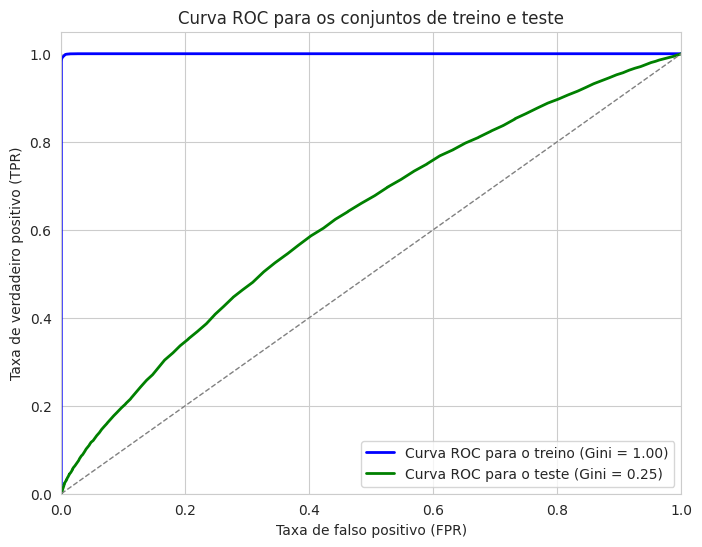

In [48]:
plot_roc_curve(
    data_train[target_var], data_train['rf_score'],
    data_test[target_var], data_test['rf_score']
)

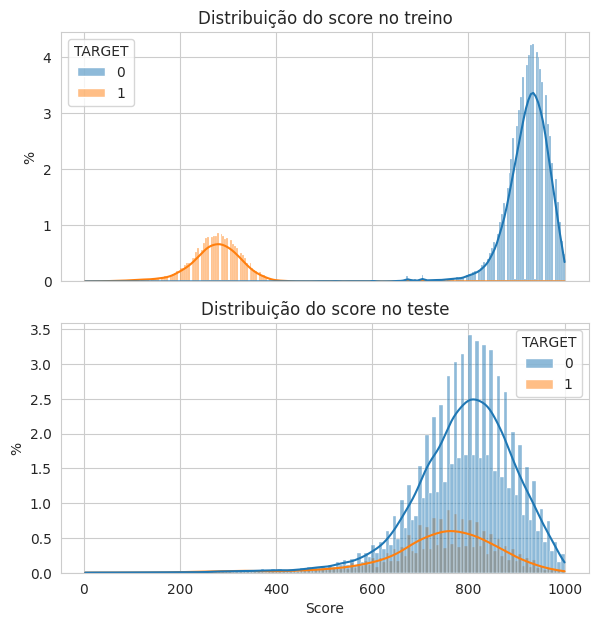

In [49]:
plot_credit_score(data_train, data_test, 'rf_score', target_var)

## LightGBM

O LightGBM é capaz de lidar com variáveis categóricas nativamente. Entretanto, elas devem estar representadas em um formato numérico. Nessa primeira versão, os hiperparâmetros do algoritmo não foram otimizados.

In [50]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-999)

X_train_preproc_oe = pd.DataFrame(
    encoder.fit_transform(X_train_preproc[cat_vars]),
    columns=cat_vars
)
X_train_preproc_oe = X_train_preproc[num_vars].join(X_train_preproc_oe)

X_test_preproc_oe = pd.DataFrame(
    encoder.transform(X_test_preproc[cat_vars]),
    columns=cat_vars
)
X_test_preproc_oe = X_test_preproc[num_vars].join(X_test_preproc_oe)

X_oot_preproc_oe = pd.DataFrame(
    encoder.transform(X_oot_preproc[cat_vars]),
    columns=cat_vars
)
X_oot_preproc_oe = X_oot_preproc[num_vars].join(X_oot_preproc_oe)

In [51]:
X_train_preproc.shape, X_train_preproc_oe.shape

((104704, 125), (104704, 125))

In [52]:
lgbm_model = LGBMClassifier(
    n_estimators=200, n_jobs=-1, random_state=1989, verbosity=-1
)
lgbm_model.fit(X_train_preproc_oe, y_train, categorical_feature=cat_vars)
lgbm_model

LGBMClassifier(n_estimators=200, n_jobs=-1, random_state=1989, verbosity=-1)

In [53]:
data_train['lgbm_score'] = get_credit_score(lgbm_model, X_train_preproc_oe)
data_test['lgbm_score'] = get_credit_score(lgbm_model, X_test_preproc_oe)

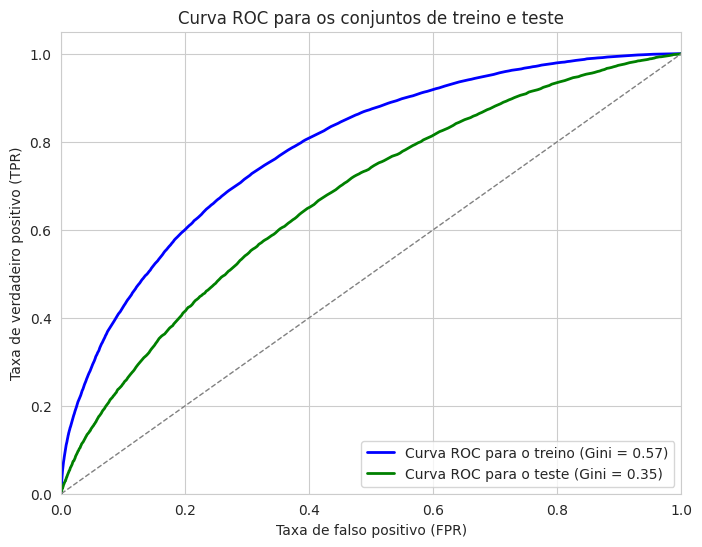

In [54]:
plot_roc_curve(
    data_train[target_var], data_train['lgbm_score'],
    data_test[target_var], data_test['lgbm_score']
)

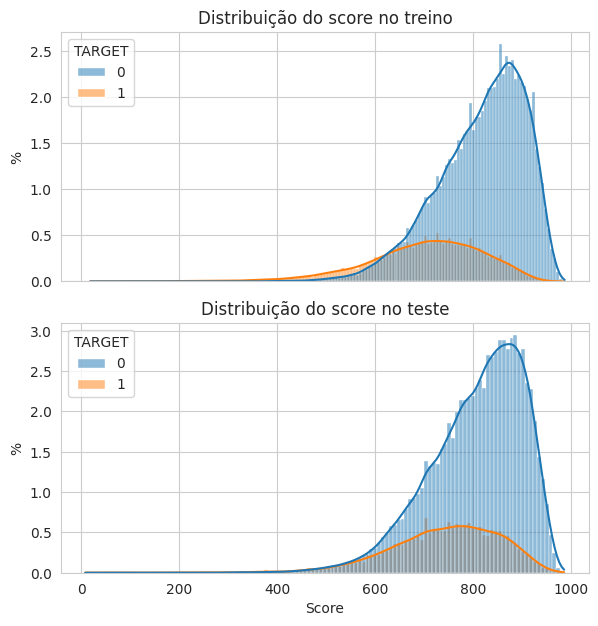

In [55]:
plot_credit_score(data_train, data_test, 'lgbm_score', target_var)

## LightGBM + otimização de hiperparâmetros

Na segunda versão do modelo usando LightGBM, foi feita otimização de hiperparâmetros por meio da biblioteca Hyperopt, que utiliza um algoritmo de otimização Bayesiana, o TPE. A escolha da melhor combinação foi feita com base na métrica AUC, utilizando validação cruzada *k-fold* com 5 folds.

In [56]:
# Definição do espaço de busca
lgbm_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'max_depth': hp.quniform('max_depth', 3, 8, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 1),
    'min_child_samples': hp.quniform('min_child_samples', 50, 1000, 10),
    'data_sample_strategy': hp.choice(
        'data_sample_strategy', ['bagging', 'goss']
    )
}

In [57]:
# Função objetivo da otimização
def lgbm_objective(params: dict) -> dict:
    '''Função objetivo da otimização de hiperparâmetros do LGBMClassifier.

    Params
    ------
    params: dict
        Dicionário com as seguintes chaves:
            'X': tabela com as variáveis explicativas.
            'y': vetor com a variável resposta.
            'seed': semente do gerador de números aleatórios.
            'search_space: configuração do espaço de busca de hiperparâmetros.
            'cat_vars': Lista de variáveis categóricas.

    Retorna
    -------
    dict
        Resultados de uma iteração de otimização.
    '''
    X = params['X']
    y = params['y']
    seed = params['seed']
    space = params['search_space']
    cat_vars = params['cat_vars']

    space['n_estimators'] = int(space['n_estimators'])
    space['max_depth'] = int(space['max_depth'])
    space['num_leaves'] = int(space['num_leaves'])
    space['min_child_samples'] = int(space['min_child_samples'])

    model = LGBMClassifier(
        n_jobs=-1, random_state=seed, verbosity=-1, **space
    )

    cv = KFold(n_splits=5, random_state=seed, shuffle=True)

    auc = cross_val_score(
        model, X, y, scoring='roc_auc', cv=cv, verbose=0, n_jobs=4,
        params={'categorical_feature': cat_vars}
    ).mean()
    gini = 2 * auc - 1


    return {'loss': -gini, 'status': STATUS_OK}

In [58]:
def train_lgbm(
    X: pd.DataFrame,
    y: pd.Series,
    seed: int,
    search_space: dict,
    cat_vars: Optional[List[str]] = None,
    max_evals_hpo: Optional[int] = 5
) -> LGBMClassifier:
    '''Treinar um classificador do LightGBM.

    É feita otimização dos hiperparâmetros do LightGBM usando Hyperopt (TPE).

    Params
    ------
    X: pandas.DataFrame
        Tabela com as variáveis explicativas.
    y: pandas.Series
        Variável resposta.
    seed: int
        Semente do gerador de números aleatórios.
    search_space: dict
        Espaço de busca de hiperparâmetros no formato do Hyperopt.
    cat_vars: Optional[List[str]] (default=None)
        Lista de variáveis categóricas.
    max_evals_hpo: Optional[int]
        Número de iterações da otimização de hiperparâmetros.

    Retorna
    -------
    lightgbm.LGBMClassifier
        Modelo treinado.
    '''
    # Otimização de hiperparâmetros
    trials = Trials()

    params = {
        'X': X,
        'y': y,
        'seed': seed,
        'search_space': search_space,
        'cat_vars': cat_vars
    }

    best_params = fmin(
        fn=lgbm_objective,
        space=params,
        algo=tpe.suggest,
        max_evals=max_evals_hpo,
        trials=trials,
        rstate=np.random.default_rng(seed * len(X.columns))
    )

    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['num_leaves'] = int(best_params['num_leaves'])
    best_params['min_child_samples'] = int(best_params['min_child_samples'])
    
    strategy_options = ['bagging', 'goss']
    best_params['data_sample_strategy'] = strategy_options[
        best_params['data_sample_strategy']
    ]

    # Treino do modelo final
    model = LGBMClassifier(
        n_jobs=-1, random_state=seed, verbosity=-1, **best_params
    )
    model.fit(X, y, categorical_feature=cat_vars)

    return model

In [59]:
lgbm_hpo_model = train_lgbm(
    X=X_train_preproc_oe,
    y=y_train,
    seed=seed,
    search_space=lgbm_space,
    cat_vars=cat_vars,
    max_evals_hpo=num_evals_hpo
)
lgbm_hpo_model

100%|██████████| 15/15 [10:12<00:00, 40.84s/trial, best loss: -0.34360025560192997]


LGBMClassifier(colsample_bytree=np.float64(0.9426110604529843),
               data_sample_strategy='bagging',
               learning_rate=np.float64(0.07137066105691785), max_depth=4,
               min_child_samples=860, n_estimators=710, n_jobs=-1,
               num_leaves=52, random_state=1989,
               reg_alpha=np.float64(1.2724293092489842),
               reg_lambda=np.float64(5.632042248655392),
               subsample=np.float64(0.9032802091153767), verbosity=-1)

In [60]:
data_train['lgbm_hpo_score'] = get_credit_score(
    lgbm_hpo_model, X_train_preproc_oe
)
data_test['lgbm_hpo_score'] = get_credit_score(
    lgbm_hpo_model, X_test_preproc_oe
)

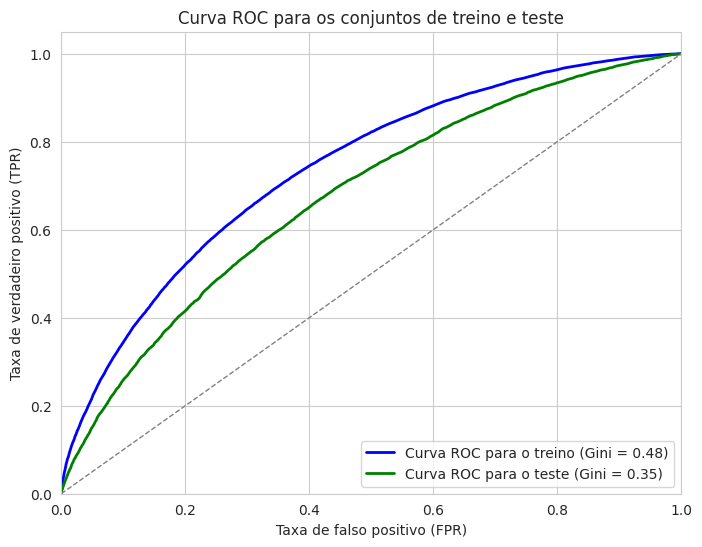

In [61]:
plot_roc_curve(
    data_train[target_var], data_train['lgbm_hpo_score'],
    data_test[target_var], data_test['lgbm_hpo_score']
)

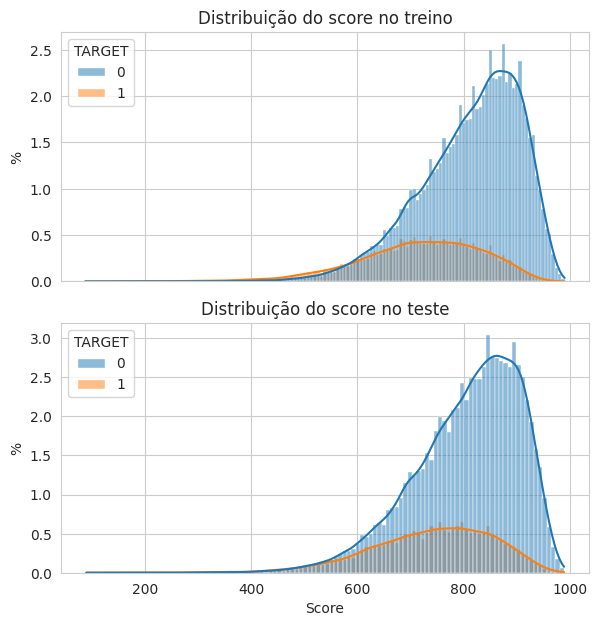

In [62]:
plot_credit_score(data_train, data_test, 'lgbm_hpo_score', target_var)

# Análise técnica dos modelos

O Gini dos modelos Random Forest, LightGBM e LightGBM + HPO (com otimização de hiperparâmetros) foi comparado nos conjuntos de treino e teste.

O modelo Random Forest apresentou forte *overfitting*, com Gini de 1 no treino, mas 0,25 no teste. Ambos os modelos LightGBM apresentaram *overfitting*, mas em um grau menor do que o Random Forest. O modelo sem otimização de hiperparâmetros teve um resultado melhor no treino, com um Gini de 0,57. A otimização provavelmente poderia encontar resultados melhores com um número maior de iterações, ao custo de tempo de processamento.

Para reduzir o *overfitting*, seria possível alterar o espaço de busca, alterando os intervalos de alguns hiperparâmetros, como regularização, profundidade máxima das árvores, número de folhas, porcentagem das amostragens das variáveis e das observações, dentre outros. Além disso, por se tratar de um modelo de *boosting*, que prioriza as observações classificadas de forma errada, o LightGBM pode ser sensível à presença de muitas observações *outlier*, que poderiam ser identificadas por algoritmos como Isolation Forest ou a clusterização DBSCAN e tratados ou removidos.

In [63]:
models = ['Random Forest', 'LightGBM', 'LightGBM + HPO']
scores = ['rf_score', 'lgbm_score', 'lgbm_hpo_score']

ginis = []

for model, score in zip(models, scores):
    gini_train = -utils.gini(data_train[target_var], data_train[score])
    gini_test = -utils.gini(data_test[target_var], data_test[score])

    ginis.append((model, 'Treino', gini_train))
    ginis.append((model, 'Teste', gini_test))

ginis = pd.DataFrame(ginis, columns=['modelo', 'conj', 'gini']).set_index(
    ['modelo', 'conj']
)
ginis.map(lambda x: f'{x:.2f}')

gini
modelo         conj        
Random Forest  Treino  1.00
               Teste   0.25
LightGBM       Treino  0.57
               Teste   0.35
LightGBM + HPO Treino  0.48
               Teste   0.35

In [64]:
model = lgbm_model
score = 'lgbm_score'

utils.save_pickle(
    model,
    os.path.join(
        artifacts_config['dir'],
        artifacts_config['model_file']
    )    
)

In [65]:
data_oot[score] = get_credit_score(
    lgbm_hpo_model, X_oot_preproc_oe
)

utils.save_csv(data_oot, data_config['output_oot_file'])

## Estabilidade

Com base nos resultados anteriores, o modelo LightGBM com otimização de hiperparâmetros foi escolhido.O Gini foi avaliado em cada safra e se mostrou estável, tanto no treino quanto no teste.

In [66]:
def get_monthly_gini(
    data_train: pd.DataFrame,
    data_test: pd.DataFrame,
    ym_var: str,
    score_var: str
) -> pd.DataFrame:
    '''Calcular o Gini para cada safra.

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
    data_test: pandas.DataFrame
        Dados de teste.
    ym_var: str
        Nome da variável de safra.
    score_var: str
        Nome da variável com o score do modelo.

    Retorna
    -------
    pandas.DataFrame
        Tabela com o Gini de cada conjunto em cada safra.
    '''
    monthly_ginis = []

    for ym in sorted(data_train[ym_var].unique().tolist()):
        # Filtrar os dados por safra
        data_train_ym = data_train[data_train[ym_var] == ym]
        data_test_ym = data_test[data_test[ym_var] == ym]

        # Calcular o gini da safra
        gini_train = -utils.gini(
            data_train_ym[target_var], data_train_ym[score_var]
        )
        gini_test = -utils.gini(
            data_test_ym[target_var], data_test_ym[score_var]
        )

        monthly_ginis.append((ym, 'Treino', gini_train))
        monthly_ginis.append((ym, 'Teste', gini_test))

    return pd.DataFrame(
        monthly_ginis, columns=[ym_var, 'conj', 'gini']
    )

In [67]:
def plot_monthly_gini(data: pd.DataFrame, ym_var: str) -> None:
    '''Criar um gráfico com o Gini ao longo das safras.
    
    Params
    ------
    data: pandas.DataFrame
        Tabela de Gini por safra.
    ym_var: str
        Nome da variável de safra.
    '''
    plt.figure(figsize=(10, 4))

    sns.lineplot(data=data, x=ym_var, y='gini', hue='conj')

    plt.ylim(bottom=0)
    plt.ylabel('Gini')
    plt.xlabel('')
    plt.title('Estabilidade do Gini nas safras')
    plt.legend(title='Conjunto')

    plt.show()

In [68]:
monthly_ginis = get_monthly_gini(
    data_train, data_test, ym_var, score
)
monthly_ginis.set_index([ym_var, 'conj']).map(lambda x: f'{x:.2f}')

gini
REF    conj        
201701 Treino  0.57
       Teste   0.34
201702 Treino  0.60
       Teste   0.37
201704 Treino  0.58
       Teste   0.35
201705 Treino  0.55
       Teste   0.32
201706 Treino  0.58
       Teste   0.36
201707 Treino  0.55
       Teste   0.35
201708 Treino  0.56
       Teste   0.34

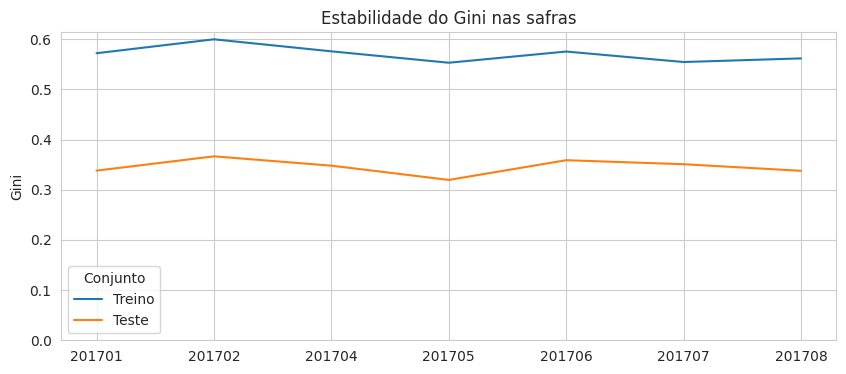

In [69]:
plot_monthly_gini(monthly_ginis, ym_var)

## Importância das variávais

A importância das variáveis foi avaliado por meio do SHAP no conjunto de teste.

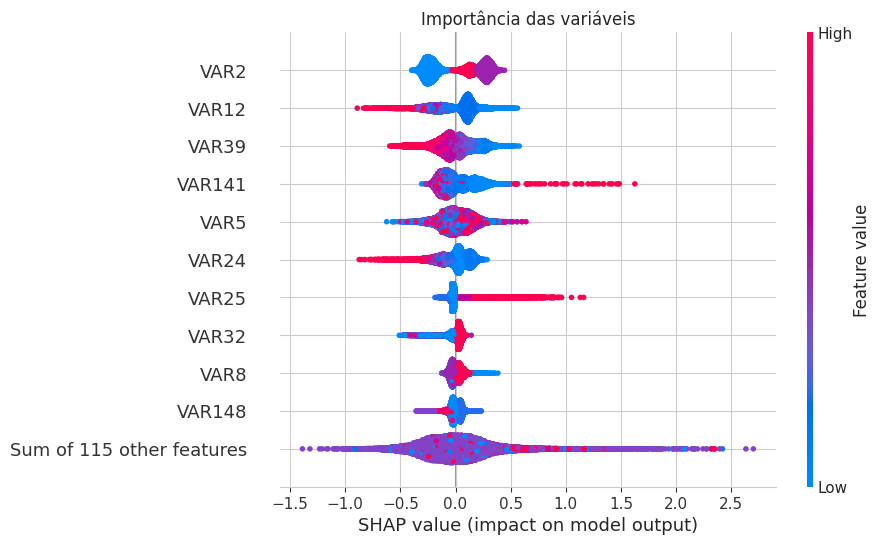

In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_preproc_oe[exp_vars])

shap.plots.beeswarm(shap_values, max_display=11, show=False)
plt.title('Importância das variáveis')
plt.show()

### Distribuição das 5 variáveis mais importantes

A distribuição das 5 variáveis mais importantes é estável ao longo do tempo e semelhante entre os conjuntos de treino e teste, conforme pode ser visto pelos gráficos e pelo teste estatístico de Kolmogorov-Smirnov. Além disso, o porcentagem de missing dessas vairáveis é equivalente em ambos os conjuntos. Com base nas 5 variáveis mais importantes do modelo, não parece ter ocorrido *data shift* que poderia explicar a perda de discriminação no conjunto de teste.

In [71]:
def plot_distrib(
    data_train: pd.DataFrame,
    data_test: pd.DataFrame,
    var: str,
    ym_var: str
) -> None:
    '''Criar gráficos da distribuição de uma variável e da média ao longo das
    safras nos conjuntos de treino e teste.

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
        
    data_test: pandas.DataFrame
        Dados de teste.
    var: str
        Nome da variável a ser avaliada.
    ym_var: str
        Nome da variável de safra.
    '''
    if data_train[var].dtype != 'object':  # Variável numérica
        _, ax = plt.subplots(1, 2, figsize=(12, 4))

        # Distribuição geral
        sns.kdeplot(data=data_train, x=var, label='Treino', ax=ax[0])
        sns.kdeplot(data=data_test, x=var, label='Teste', ax=ax[0])
        ax[0].legend(title='Conjunto')
        ax[0].set_ylabel('Densidade')
        ax[0].set_xlabel('')

        # Média ao longo do tempo
        sns.lineplot(data=data_train, x=ym_var, y=var, ax=ax[1], label='Treino')
        sns.lineplot(data=data_test, x=ym_var, y=var, ax=ax[1], label='Teste')
        ax[1].legend().remove()
        ax[1].set_ylabel('Valor')
        ax[1].set_xlabel('')
        ax[1].set_ylim(bottom=0)
        plt.xticks(rotation=45)
        
        plt.suptitle(f'Distribuição da variável {var}')
    else:  # Variável categórica
        plt.figure(figsize=(6, 4))

        data_train2 = pd.DataFrame(data_train[var])
        data_train2['Conjunto'] = 'Treino'

        data_test2 = pd.DataFrame(data_test[var])
        data_test2['Conjunto'] = 'Teste'

        data_full = pd.concat([data_train2, data_test2]).reset_index(drop=True)
        data_full.head()

        sns.countplot(data=data_full, x=var, hue='Conjunto', stat='percent')
        plt.ylabel('%')
        plt.xlabel('')
        plt.title(f'Distribuição da variável {var}')

    plt.show()

In [72]:
def ks_test(
    data_train: pd.DataFrame,
    data_test: pd.DataFrame,
    var: str
) -> None:
    '''Executar o teste de Kolmogorov-Smirnov para comparar as distribuições
    de treino e teste.

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
    data_test: pandas.DataFrame
        Dados de teste.
    var: str
        Nome da variável a ser avaliada.
    '''
    ks_res = ks_2samp(
        data_train[var].dropna(),
        data_test[var].dropna()
    )

    if ks_res.pvalue <= 0.05:
        print('As distribuições do treino e teste são diferentes.')
    else:
        print(
            'Sem evidência que as distribuições do treino e teste ' \
            'são diferentes.'
        )

In [73]:
# Variáveis explicativas ordenadas por importância
mean_abs_shap = pd.DataFrame({
    'feature': shap_values.feature_names,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Top 5 variáveis
top5_feats = mean_abs_shap['feature'].head(5)

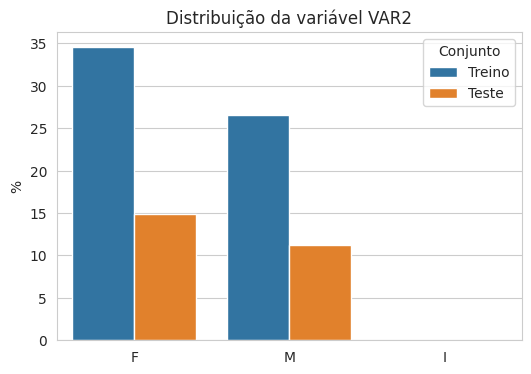

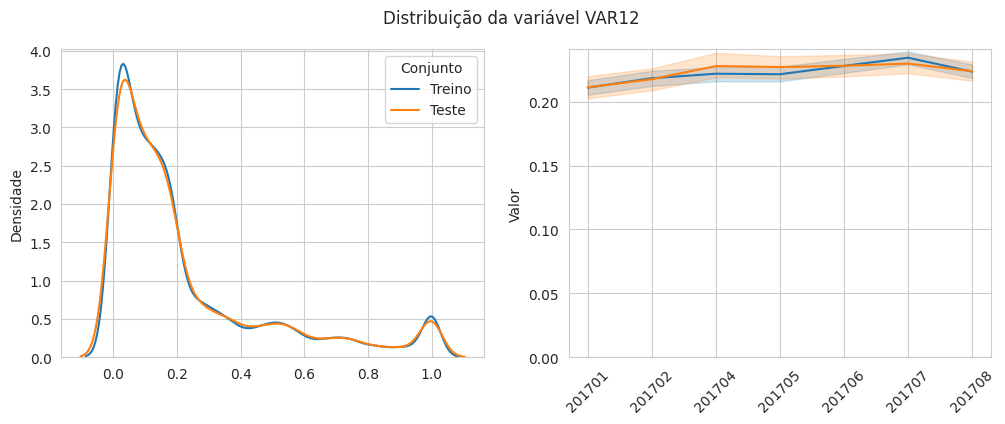

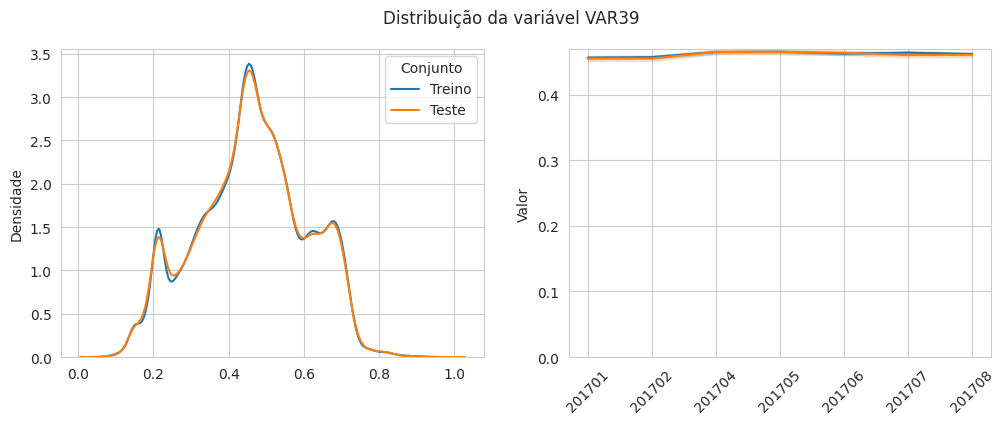

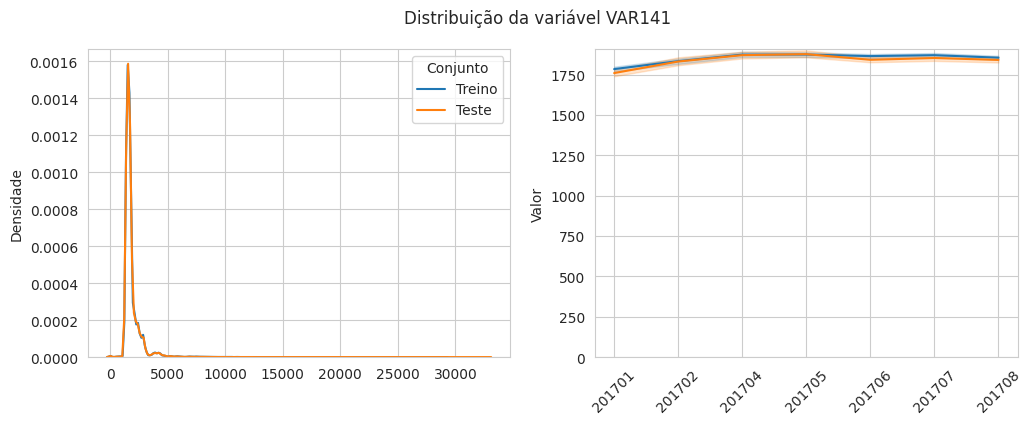

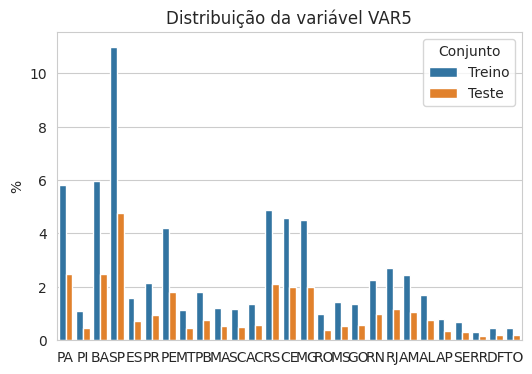

In [74]:
for var in top5_feats:
    plot_distrib(data_train, data_test, var, ym_var)

In [75]:
for var in top5_feats:
    print(f'Variável {var}:')
    print()
    ks_test(data_train, data_test, var)
    print()
    print('-' * 50)
    print()

Variável VAR2:

Sem evidência que as distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR12:

Sem evidência que as distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR39:

Sem evidência que as distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR141:

Sem evidência que as distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR5:

Sem evidência que as distribuições do treino e teste são diferentes.

--------------------------------------------------



In [76]:
print('Quantidade de missing nas 5 variáveis mais importantes:')

pd.DataFrame({
    'Teste': data_train[top5_feats].isna().mean(),
    'Treino': data_test[top5_feats].isna().mean()
}).map(lambda x: f'{x:.1%}')

Quantidade de missing nas 5 variáveis mais importantes:


,Teste,Treino
VAR2,12.7%,12.8%
VAR12,45.7%,46.0%
VAR39,0.1%,0.1%
VAR141,0.0%,0.0%
VAR5,2.8%,2.7%


# Análise financeira

A política vigente, chamada `AS-IS`, reprova todas as solicitações de crédito feitas por clientes com menos de 28 anos. Já a política proposta, chamada de `TO-BE`, utiliza o score de crédito para reprovar a mesma porcentagem de clientes, mas levando em consideração a probabilidade de inadimplência. A tabela abaixo compara os resultados das duas políticas.

|                          | **Política `AS-IS`** | **Política `TO-BE`** | **Diferença** |
|--------------------------|:--------------------:|:--------------------:|:-------------:|
| **Carteira de crédito**  |       R$543.200      |       R$552.200      |    R$9.000    |
| **Dívida total**         |       R$86.300       |       R$78.600       |    -R$7.700   |
| **Solicitações negadas** |         25,6%        |         24,4%        |     -1,2%     |

A política proposta resulta em um aumento de R$9.000 na carteira de crédito, acompanhada de uma redução de R$7.700 na dívida total.

In [77]:
data_financ = data_test[data_test[ym_var] == '201708'].copy()
data_financ['VALOR_EMPRESTIMO'] = 100

## Política `AS-IS`

In [78]:
data_financ['POL_AS_IS'] = data_financ[age_var].map(
    lambda age: 'Aprovado' if age > 28 else 'Negado'
)
data_financ[[target_var, age_var, 'POL_AS_IS']].head()

,TARGET,IDADE,POL_AS_IS
37604,0,35.337,Aprovado
37605,1,32.975,Aprovado
37606,1,29.619,Aprovado
37607,0,NaN,Negado
37608,0,32.189,Aprovado


In [79]:
data_financ.groupby('POL_AS_IS')[age_var].describe()

,count,mean,std,min,25%,50%,75%,max
POL_AS_IS,,,,,,,,
Aprovado,5432.0,47.219198,13.347311,28.016,35.9495,44.9575,56.76400,94.063
Negado,1372.0,23.252531,2.833713,18.014,20.8675,23.3245,25.77725,28.000


In [80]:
# Tamanho da carteira
as_is_credit_port = data_financ[
    data_financ['POL_AS_IS'] == 'Aprovado'
]['VALOR_EMPRESTIMO'].sum()

# Dívida total
as_is_loss = data_financ[
    (data_financ['POL_AS_IS'] == 'Aprovado') &
    (data_financ[target_var] == 1)
]['VALOR_EMPRESTIMO'].sum()

# Porcentagem de negados
perc_denied = data_financ['POL_AS_IS'].value_counts(normalize=True)['Negado']

print('Política AS-IS:')
print('---------------')
print()
print(f'Carteira de crédito:  R${as_is_credit_port:,d}')
print(f'Dívida total:         R${as_is_loss:,d}')
print(f'Solicitações negadas: {perc_denied:.1%}')

Política AS-IS:
---------------

Carteira de crédito:  R$543,200
Dívida total:         R$86,300
Solicitações negadas: 25.6%


## Política `TO-BE`

In [81]:
# O ponto de corte deve ser o percentil equivalente à porcentagem de negados no AS-IS
score_threshold = data_test[score].quantile(perc_denied)

print('Ponto de corte do score de crédito na política TO-BE:', int(score_threshold))

Ponto de corte do score de crédito na política TO-BE: 733


In [82]:
# Cálculo da política TO-BE
data_financ['POL_TO_BE'] = data_financ[score].map(
    lambda score: 'Aprovado' if score >= score_threshold else 'Negado'
)
data_financ[[target_var, score, 'POL_TO_BE']].head()

,TARGET,lgbm_score,POL_TO_BE
37604,0,893,Aprovado
37605,1,900,Aprovado
37606,1,803,Aprovado
37607,0,603,Negado
37608,0,727,Negado


In [83]:
# Tamanho da carteira
to_be_credit_port = data_financ[
    data_financ['POL_TO_BE'] == 'Aprovado'
]['VALOR_EMPRESTIMO'].sum()

# Dívida total
to_be_loss = data_financ[
    (data_financ['POL_TO_BE'] == 'Aprovado') &
    (data_financ[target_var] == 1)
]['VALOR_EMPRESTIMO'].sum()

# Porcentagem de negados
to_be_perc_denied = data_financ['POL_TO_BE'].value_counts(normalize=True)['Negado']

print('Política TO-BE:')
print('---------------')
print()
print(f'Carteira de crédito:  R${to_be_credit_port:,d}')
print(f'Dívida total:         R${to_be_loss:,d}')
print(f'Solicitações negadas: {to_be_perc_denied:.1%}')

Política TO-BE:
---------------

Carteira de crédito:  R$552,200
Dívida total:         R$78,600
Solicitações negadas: 24.4%


In [84]:
policy_comp = pd.DataFrame({
    'Política': ['AS-IS', 'TO-BE'],
    'Carteira': [as_is_credit_port, to_be_credit_port],
    'Dívida': [as_is_loss, to_be_loss]
})
policy_comp.map(lambda x: f'R${x:,d}' if isinstance(x, int) else x)

,Política,Carteira,Dívida
0,AS-IS,"R$543,200","R$86,300"
1,TO-BE,"R$552,200","R$78,600"


In [85]:
port_increase = policy_comp.loc[1, 'Carteira'] - policy_comp.loc[0, 'Carteira']
economy = policy_comp.loc[0, 'Dívida'] - policy_comp.loc[1, 'Dívida']

print(f'Aumento da carteira de crédito:      R${port_increase:,d}.')
print(f'Economia gerada pela política TO-BE: R${economy:,d}.')

Aumento da carteira de crédito:      R$9,000.
Economia gerada pela política TO-BE: R$7,700.
